In [1]:
import pandas as pd
import numpy as np

import itertools
import random
from math import sqrt
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler #Scaling Exogenous values only. 

In [2]:
df = pd.read_csv('Jacksonville KPI 2023.csv', parse_dates=['Date of Service'], index_col = 'Date of Service')

#Differencing the 'Actual Trips' column due to a p_value greater than 0.05
df['Actual Trips Diff']=df['Actual Trips'].diff()

#Dropping the NaN values resulting from differencing
df.dropna(inplace = True)

pd.DataFrame(df)

,Actual Trips,Operating Hours,Turn Down Transports,Actual Trips Diff
Date of Service,,,,
2023-01-03,5.0,14.16,5.0,4.0
2023-01-04,4.0,21.16,2.0,-1.0
2023-01-05,11.0,39.12,6.0,7.0
2023-01-06,9.0,21.65,4.0,-2.0
2023-01-07,8.0,30.07,1.0,-1.0
...,...,...,...,...
2024-01-10,19.0,53.55,8.0,5.0
2024-01-11,11.0,27.25,3.0,-8.0
2024-01-12,23.0,55.77,8.0,12.0


In [3]:
#Using the Dickery-Fuller test, testing 'Actual Trips Diff' for stationary
result_diff = adfuller(df['Actual Trips Diff'])
print('ADF Statistic: %f' % result_diff[0])
print('p-value %f' % result_diff[1])

ADF Statistic: -7.542145
p-value 0.000000


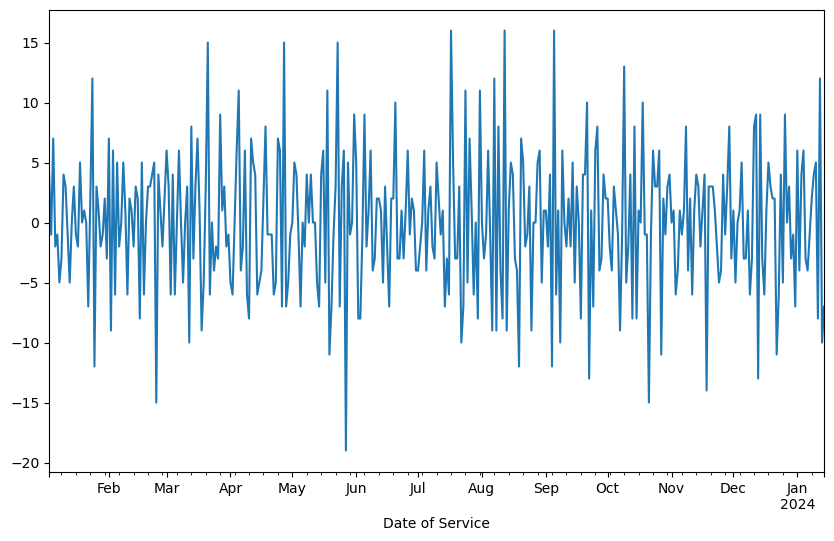

In [4]:
#Visualizing the Differenced Series
df['Actual Trips Diff'].plot(figsize=(10,6))
plt.show()

In [5]:
#We are training the model with best params of all three columns. Generating the report for 2 weeks is next section. 
#Train-Test Split
train_end = pd.to_datetime('11/30/2023') #End-Date for training, not for entire dataset
train = df.loc[:train_end]
test = df.loc[train_end + pd.Timedelta(days=1):] #The rest of the dates
#pd.DataFrame(train)
pd.DataFrame(test)

,Actual Trips,Operating Hours,Turn Down Transports,Actual Trips Diff
Date of Service,,,,
2023-12-01,17.0,40.00,2.0,1.0
2023-12-02,12.0,31.74,11.0,-5.0
2023-12-03,12.0,32.44,2.0,0.0
2023-12-04,13.0,44.03,12.0,1.0
2023-12-05,18.0,48.24,4.0,5.0
2023-12-06,15.0,49.26,3.0,-3.0
2023-12-07,12.0,52.17,5.0,-3.0
2023-12-08,13.0,30.97,12.0,1.0
2023-12-09,7.0,23.93,13.0,-6.0


In [6]:
#Fitting the SARIMA Model for Exogenous Variable: Operating Hours 
#Best Parameters: (1, 1, 1, 0, 1, 2, 30); old value
#Best Parameters: (1, 0, 0, 1, 1, 2, 30)

operating_hours_series = train['Operating Hours']

exog_train_OpHr = train[['Actual Trips', 'Turn Down Transports']]
exog_test_OpHr = test[['Actual Trips', 'Turn Down Transports']]

sarima_model_OpHr = SARIMAX(operating_hours_series, exog = exog_train_OpHr, #Unsure to use exog here.
               order = (1,0,0), #Using best parameters determined from testing
               seasonal_order = (1,1,2,30))

sarima_model_fit_OpHr = sarima_model_OpHr.fit(disp=False)

#Forecasting for rest of the dataset in test
operating_hours_forecast = sarima_model_fit_OpHr.forecast(steps=len(test), exog = exog_test_OpHr) #Unsure to use exog here.

C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
#Fitting the SARIMA Model for Exogenous Variable: Turn Down Transports
#Best Parameters: (1, 0, 0, 2, 2, 1, 14); old value
#Best Parameters: (0, 2, 2, 2, 0, 1, 30)

turn_down_transports_series = train['Turn Down Transports']

exog_train_TDT = train[['Actual Trips', 'Operating Hours']]
exog_test_TDT= test[['Actual Trips', 'Operating Hours']]

sarima_model_TDT = SARIMAX(turn_down_transports_series, exog = exog_train_TDT, #Unsure to use exog here.
               order = (0,2,2), #Here d=1 to indicate first differencing
               seasonal_order = (2,0,1,30))
               #exog=exog) This is the X in SARIMAX. Taking it out to use SARIMA instead
    
sarima_model_fit_TDT = sarima_model_TDT.fit(disp=False)

#Forecasting for rest of the dataset in test
turn_down_transports_forecast = sarima_model_fit_TDT.forecast(steps=len(test), exog = exog_test_TDT) #Unsure to use exog here.

C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [8]:
operating_hours_forecast

2023-12-01    48.886491
2023-12-02    35.682791
2023-12-03    39.708849
2023-12-04    40.863688
2023-12-05    47.752050
2023-12-06    43.635945
2023-12-07    37.936812
2023-12-08    35.042915
2023-12-09    21.621124
2023-12-10    20.174887
2023-12-11    32.532935
2023-12-12    49.127462
2023-12-13    24.019877
2023-12-14    44.659356
2023-12-15    36.243106
2023-12-16    27.382100
2023-12-17    27.688457
2023-12-18    34.521443
2023-12-19    43.916619
2023-12-20    54.499032
2023-12-21    54.271451
2023-12-22    19.888202
2023-12-23     9.109687
2023-12-24    28.096433
2023-12-25    17.314259
2023-12-26    35.812995
2023-12-27    37.020368
2023-12-28    39.185846
2023-12-29    33.597162
2023-12-30    31.529642
2023-12-31    16.127072
2024-01-01    32.642372
2024-01-02    23.441297
2024-01-03    35.682100
2024-01-04    40.320557
2024-01-05    32.031433
2024-01-06    29.759460
2024-01-07    26.271211
2024-01-08    30.391065
2024-01-09    38.090749
2024-01-10    49.643482
2024-01-11    30

In [9]:
turn_down_transports_forecast

2023-12-01     9.037281
2023-12-02     9.499334
2023-12-03     8.822055
2023-12-04     7.854765
2023-12-05     8.780393
2023-12-06     7.664829
2023-12-07     7.478197
2023-12-08     9.051746
2023-12-09     8.432887
2023-12-10     8.909215
2023-12-11     9.211502
2023-12-12     8.160150
2023-12-13     8.363211
2023-12-14     8.556480
2023-12-15     9.672645
2023-12-16     9.380056
2023-12-17     9.151177
2023-12-18     8.690870
2023-12-19     7.977080
2023-12-20     7.685974
2023-12-21     7.621384
2023-12-22     8.393379
2023-12-23     9.689026
2023-12-24     8.839497
2023-12-25     9.731559
2023-12-26     9.523604
2023-12-27     8.445527
2023-12-28     8.583387
2023-12-29     8.326261
2023-12-30     8.680171
2023-12-31     9.578691
2024-01-01     9.494949
2024-01-02     8.789695
2024-01-03     9.592195
2024-01-04     8.687075
2024-01-05     9.000487
2024-01-06     9.849134
2024-01-07     9.463023
2024-01-08     8.454994
2024-01-09    10.114944
2024-01-10     8.314147
2024-01-11     8

In [10]:
#Combining Forecasts of 'Operating Hours' and 'Turn Down Transports' into a DataFrame as the new test DataFrame.
#This is different because we are dropping data after 10-15 for testing and instead using the generated values.

#future_dates = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), period = , freq = 'D')
test_exog = pd.DataFrame({
    'Operating Hours': operating_hours_forecast, #Synthetic (Generated) Data
    'Turn Down Transports': turn_down_transports_forecast}, #Synthetic (Generated) Data 
    index = test.index)

In [11]:
test_exog

,Operating Hours,Turn Down Transports
Date of Service,,
2023-12-01,48.886491,9.037281
2023-12-02,35.682791,9.499334
2023-12-03,39.708849,8.822055
2023-12-04,40.863688,7.854765
2023-12-05,47.752050,8.780393
2023-12-06,43.635945,7.664829
2023-12-07,37.936812,7.478197
2023-12-08,35.042915,9.051746
2023-12-09,21.621124,8.432887


Performing Grid Search

In [12]:
#Defining Parameter Space
p = d = q = range(0,3)
P = D = Q = range(0, 3)
s_values = [7, 14, 30]  #Testing for Weekly, Bi-Weely, and Monthly Seasonality

# Random Grid Search across all units
#pdq_combinations = list(itertools.product(p,d,q))
#seasonal_combinations = [(x[0], x[1], x[2], s) for x in list(itertools.product(P,D,Q)) for s in s_values]

# Random Grid Search across all units
parameters = list(itertools.product(p, d, q, P, D, Q, s_values))
pdq_combinations = random.sample(parameters, min(len(parameters), 10))  # Randomly sample combinations to list of 10.
#If not, then there would be a huge list to try out and it just takes too long. That's why the previous 2 lines of code take 
#a long time to finish. Need a stronger PC to run. Meanwhile, Keep running these 2 lines until you get a low AIC. 

In [13]:
#To illistrate the difference in the size of each list. 
pdq_combinations

[(1, 2, 2, 0, 2, 2, 30),
 (2, 1, 2, 1, 0, 2, 7),
 (0, 0, 0, 0, 0, 0, 14),
 (1, 0, 2, 1, 0, 2, 7),
 (1, 0, 0, 1, 1, 0, 7),
 (1, 1, 1, 1, 0, 2, 30),
 (0, 1, 1, 2, 1, 1, 7),
 (0, 0, 2, 2, 2, 0, 30),
 (2, 0, 2, 0, 1, 0, 7),
 (0, 0, 0, 0, 2, 0, 14)]

In [14]:
#Grid Search Function that returns lowest AIC

#A lot to compute
#def sarimax_grid_search(data, exog_data, pdq_combinations, seasonal_combinations): #Order and seasonal order separated.
    
#Less to compute
def sarimax_grid_search(data, exog_data, pdq_combinations): #Aggregated order and seasonal order. 
    best_aic = float("inf")
    best_configuration = None
    best_model = None

#     #For stronger computers. 
#     for pdq in pdq_combinations:
#         for seasonal_combination in seasonal_combinations:
#             try:
#                 model = SARIMAX(data, order = pdq, seasonal_order = seasonal_combination, exog = exog_data,
#                                 enforce_stationarity=False, enforce_invertibility=False)
#                 model_fit = model.fit(disp=False)

    #For lesser computers.
    for pdq in pdq_combinations:
        try:
            model = SARIMAX(data, order=pdq[:3], seasonal_order=pdq[3:], exog = exog_data, 
                            enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)

            if model_fit.aic < best_aic: #Depending on what for loop block, we need to indent.
                best_aic = model_fit.aic
                #best_configuration = (pdq, seasonal_combination)
                best_configuration = pdq
                best_model = model_fit

        except Exception as e: #Depending on what for loop block, we need to indent.
            print(e)
            continue
            
    if best_configuration is None:
        raise ValueError("No suitable model parameters found for aggregate data")
            
    return best_aic, best_configuration, best_model

In [15]:
#Running Grid Search

#ts_data = df['Actual Trips']
actual_trip_series = train['Actual Trips']

exog_train = train[['Operating Hours', 'Turn Down Transports']]
exog_test = test_exog[['Operating Hours', 'Turn Down Transports']]

#Scaling exogenous values only
scaler = StandardScaler()
exog_train = scaler.fit_transform(exog_train)
exog_test = scaler.fit_transform(exog_test)

#For stronger PC
#best_aic, best_configuration, best_model = sarimax_grid_search(ts_data, exog_train, pdq_combinations, seasonal_combinations)

#For lesser PC
best_aic, best_configuration, best_model = sarimax_grid_search(actual_trip_series, exog_train, pdq_combinations)

print(f"Best SARIMAX parameters: {best_configuration} with AIC: {best_aic}")

C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.p

Best SARIMAX parameters: (1, 2, 2, 0, 2, 2, 30) with AIC: 1144.5386387364806


The difference here is that we are training normally, but then testing against synthetic exogenous value data.

Best SARIMAX: (1, 2, 2, 0, 2, 2, 30) - MSE: 40.79179236553726, MAE: 5.79674580267331, RMSE: 6.38684525924476


<function matplotlib.pyplot.show(close=None, block=None)>

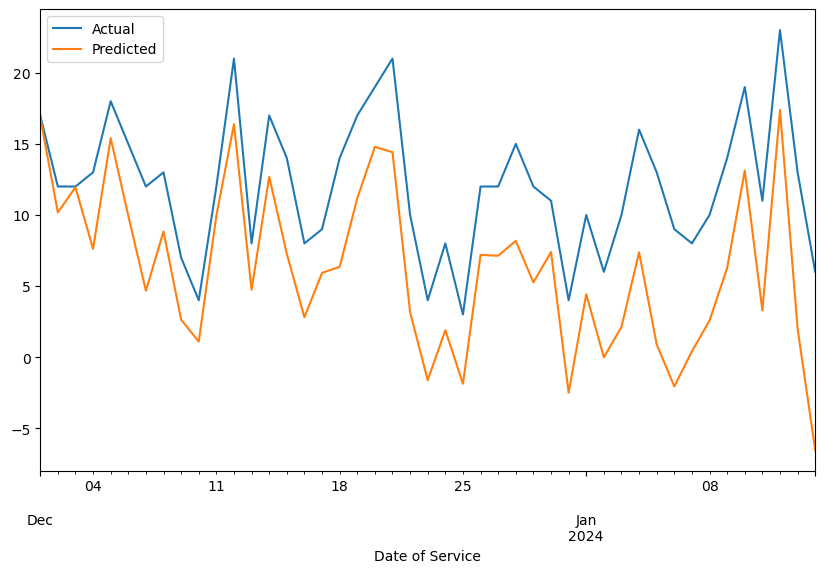

In [16]:
#Predicting the rest of the forecast to compare to test data. Steps has to be the remaining days to predict. 
#Best SARIMAX: (2, 1, 2, 2, 1, 0, 30) - MSE: 4.246802901085599, MAE: 1.7041859768544327, RMSE: 2.060777256543171 old value
#Best SARIMAX: (0, 2, 2, 1, 0, 2, 30) - MSE: 12.101160416437203, MAE: 2.980698238944526, RMSE: 3.478672220321599
#Best SARIMAX: (2, 2, 1, 1, 1, 2, 30) - MSE: 6.229087446853229, MAE: 2.1240428774173954, RMSE: 2.4958139848260386
predictions = best_model.forecast(steps=len(test), exog = exog_test)

#Performing Metrics
mse = mean_squared_error(test['Actual Trips'], predictions)
mae = mean_absolute_error(test['Actual Trips'], predictions)
rmse = np.sqrt(mse)
print(f'Best SARIMAX: {best_configuration} - MSE: {mse}, MAE: {mae}, RMSE: {rmse}')

#Plot predictions against true values
test['Actual Trips'].plot(figsize=(10,6), legend=True, label='Actual')
predictions.plot(legend=True, label='Predicted')
plt.show